# Fourier-Domain Processing

Contents:
- Ideal lowpass filtering
- Gaussian filtering
- Homoorphic processing

In [233]:
import numpy as np

from skimage import io
from matplotlib import pyplot as plt
from matplotlib import style
from matplotlib import rcParams

In [234]:
## CONSTRUCT IMAGE
M = N = 101
m = np.arange(0,M)
n = np.arange(0,M)
mm, nn = np.meshgrid(m,n)

u0 = 10
v0 = 20
sine_image = np.sin(2*np.pi*u0*mm/(M) + 2*np.pi*v0*nn/(N))

## COMPUTE 2D DFT
fft_sine_image = np.fft.fft2(sine_image)
fft_sine_image = np.fft.fftshift(fft_sine_image)

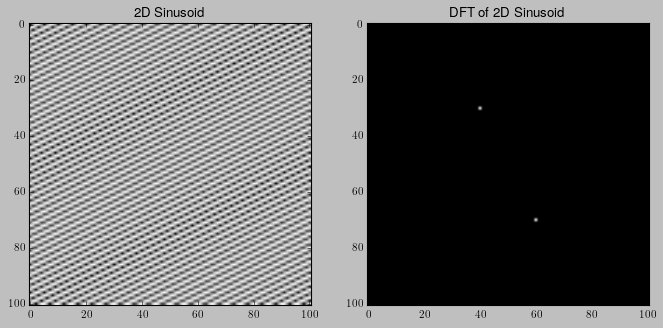

In [235]:
## PLOTS
style.use('classic')

rcParams['text.usetex'] = True
rcParams.update({'font.size': 10})
rcParams['text.latex.preamble'] = [r'\usepackage{tgheros}'] 

fig, plts = plt.subplots(1,2,figsize=(10,12))
plts[0].imshow(np.abs(sine_image), cmap='gray')
plts[0].set_title(r"2D Sinusoid")
plts[1].imshow(np.log(1+np.abs(fft_sine_image)), cmap='gray')
plts[1].set_title(r"DFT of 2D Sinusoid")
plt.show()

## Ideal Lowpass Filter

Let $f$ be an $M\times N$ image and let $F$ be the $(M,N)$-point DFT of $f$. The DFT of the isotropic ideal lowpass filter is defined as:
\begin{equation}
    H(u,v) = \begin{cases}
    1, \; u^2 + v^2 < r \\
    0, \; \text{otherwise}.
    \end{cases}
\end{equation}
The DFT of the lowpass image $f_{\text{LPF}}$ is $F_{\text{LPF}}(u,v) = F(u,v) \cdot H(u,v)$.

In [236]:
## FUNCTION DEFINITON: IDEAL LOWPASS FILTER

def ideal_lowpass_filter(image, cutoff=10):
    m,n = image.shape

    ilpf_matrix = np.zeros((m,n))
    for i in range(m):
        for j in range(n):
            if (i-m/2)**2 + (j-n/2)**2 <= cutoff**2:
                ilpf_matrix[i,j] = 1

    fft_image = np.fft.fft2(image)
    fft_image = np.fft.fftshift(fft_image)

    fft_lowpass_image = fft_image*ilpf_matrix
    fft_lowpass_image = np.fft.fftshift(fft_lowpass_image)
    lowpass_image = np.fft.ifft2(fft_lowpass_image)

    return np.abs(lowpass_image)

In [237]:
## IDEAL LOWPASS FILTER

image = io.imread('characters.tif', 0)

cutoff = 20
lowpass_image = ideal_lowpass_filter(image, cutoff)

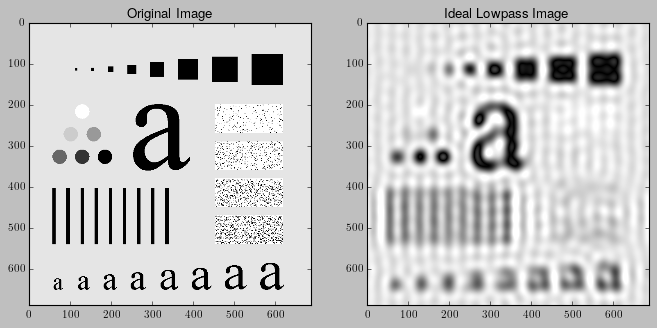

In [238]:
## PLOTS: IDEAL LOWPASS FILTER

fig, plts = plt.subplots(1,2,figsize=(10,12))
plts[0].imshow(image, vmin=0, vmax=255, cmap='gray')
plts[0].set_title(r"Original Image")
plts[1].imshow(lowpass_image, vmin=0, vmax=255, cmap='gray')
plts[1].set_title(r"Ideal Lowpass Image")
plt.show()

## Gaussian Filtering

Let $f$ be an $M\times N$ image and let $F$ be the $(M,N)$-point DFT of $f$. The DFT of a Gaussian low pass filter is defined as:
\begin{equation}
    G(u,v) = e^{-\frac{u^2+v^2}{2\sigma^2}}
\end{equation}
The DFT of the smooth image $f_{\text{G}}$ is $F_{\text{LPF}}(u,v) = F(u,v) \cdot G(u,v)$.

In [239]:
## FUNCTION DEFINITION: GAUSSIAN FILTERING

def gaussian_filter(image, var=100):
    m,n = image.shape

    gaussian_matrix = np.zeros((m,n))
    for i in range(m):
        for j in range(n):
            d = (i-m/2)**2 + (j-n/2)**2
            gaussian_matrix[i,j] = np.exp(-d/(2*var**2))

    fft_image = np.fft.fft2(image)
    fft_image = np.fft.fftshift(fft_image)

    fft_smooth_image = fft_image*gaussian_matrix
    fft_smooth_image = np.fft.fftshift(fft_smooth_image)
    smooth_image = np.fft.ifft2(fft_smooth_image)

    return np.abs(smooth_image)

In [247]:
## GAUSSIAN FILTERING

image = io.imread('characters.tif', 0)

var = 10
smooth_image = gaussian_filter(image, var)

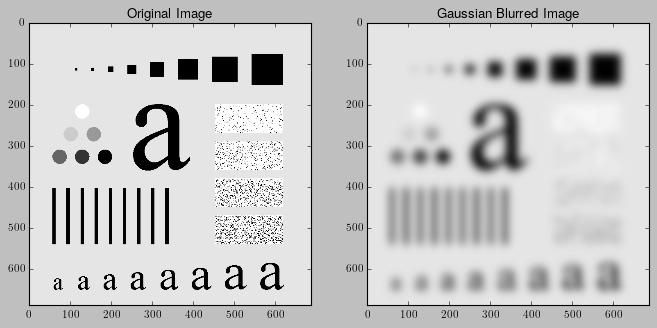

In [248]:
## PLOTS: GAUSSIAN FILTERING

fig, plts = plt.subplots(1,2,figsize=(10,12))
plts[0].imshow(image, vmin=0, vmax=255, cmap='gray')
plts[0].set_title(r"Original Image")
plts[1].imshow(smooth_image, vmin=0, vmax=255, cmap='gray')
plts[1].set_title(r"Gaussian Blurred Image")
plt.show()

## Homomorphic Filtering

Let $f$ be an $M\times N$ image and let $F$ be the DFT of $\log (f)$. Homomorphic processing of $f$ using a filter $H$ is computed using $H\cdot F$ followed by exponentiation. The homomorphic filter is designed as:
\begin{equation}
    H(u,v) = (\gamma_H - \gamma_L)\bigg(1 - e^{-\frac{u^2+v^2}{2\sigma^2}}\bigg) + \gamma_L
\end{equation}

In [242]:
## FUNCTION DEFINITION: HOMOMOPRHIC PROCESSING

def homomorphic_gaussian_filter(image, gamma=(1,2), var=300):
    m,n = image.shape
    
    homo_filter = np.zeros((m,n))
    for i in range(m):
        for j in range(n):
            d = (i-m/2.0)**2 + (j-n/2.0)**2
            homo_filter[i,j] = (gamma[1]-gamma[0])*(1-np.exp(-d/(2*var**2))) + gamma[0]

    log_image = np.log1p(np.float64(image))
    fft_log_image = np.fft.fft2(log_image)
    fft_log_image = np.fft.fftshift(fft_log_image)

    fft_homo_image = fft_log_image*homo_filter
    fft_homo_image = np.fft.ifftshift(fft_homo_image)
    homo_image = np.fft.ifft2(fft_homo_image)

    return np.exp(np.real(homo_image), dtype=np.float64)-1

In [243]:
## HOMOMORPHIC PROCESSING

image = io.imread('PET_image.tif', 0)

gamma = (0.5,6)
var = 800
contrast_enhanced_image = homomorphic_gaussian_filter(image, gamma, var)

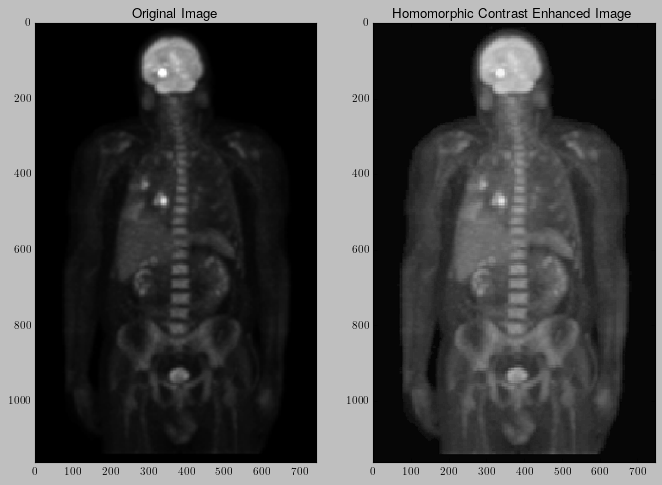

In [244]:
## PLOTS: HOMOMORPHIC PROCESSING

fig, plts = plt.subplots(1,2,figsize=(10,12))
plts[0].imshow(image, vmin=0, vmax=255, cmap='gray')
plts[0].set_title(r"Original Image")
plts[1].imshow(contrast_enhanced_image, cmap='gray')
plts[1].set_title(r"Homomorphic Contrast Enhanced Image")
plt.show()

In [269]:
## LAPLACIAN

# G = np.array([[0, 0, 1, 0, 0],
#              [0, 1, 2, 1, 0],
#              [1, 2, -16, 2, 1],
#              [0, 1, 2, 1, 0],
#              [0, 0, 1, 0, 0]])

G = np.array([[1, 1, 1, 1, 1],
             [1, 1, 1, 1, 1],
             [1, 1, -24, 1, 1],
             [1, 1, 2, 1, 1],
             [1, 1, 1, 1, 1]])

u = np.arange(-2,3)
v = np.arange(-2,3)
uu, vv = np.meshgrid(u,v)

fft_H = uu**2 + vv**2
H = np.fft.ifftshift(np.fft.ifft2(fft_H.astype(np.float64)))

k = np.arange(-5,5,0.1)
error = []
for i in range(len(k)):
    error.append(np.linalg.norm(G-k[i]*H,2))

print(k[np.argmin(error)], np.min(error))

1.0999999999999783 24.149442892699607
